In [4]:
# Voice Coding Agent Pipeline with LangGraph
# Import required libraries
import os
import json
import asyncio
from typing import Dict, List, Any, Optional, TypedDict
from dataclasses import dataclass
import speech_recognition as sr
import pyttsx3
import whisper
import tempfile
from dotenv import load_dotenv

# LangGraph and LangChain imports
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.tools import Tool
from langchain.agents import AgentExecutor
from langchain.prompts import ChatPromptTemplate

# Load environment variables
load_dotenv()

print("✅ Dependencies imported successfully!")


✅ Dependencies imported successfully!


In [5]:
# Pipeline State Definition - Enhanced for Interactive Pair Programming
class VoiceCodingState(TypedDict):
    """State for the interactive voice coding pipeline"""
    # Input data
    voice_input: Optional[str]
    current_code: Optional[str]
    code_context: Optional[str]
    
    # Processing data
    transcribed_text: Optional[str]
    confirmation_status: Optional[str]  # "confirmed", "re_record", "cancelled"
    user_intent: Optional[str]
    intent_confidence: Optional[float]
    todo_list: Optional[List[str]]
    current_todo_index: Optional[int]  # Current TODO item being worked on
    completed_todos: Optional[List[bool]]  # Track which TODOs are completed
    all_todos_completed: Optional[bool]  # Whether all TODOs are done
    current_todo_item: Optional[str]  # Current TODO item

    # Interactive pair programming features
    user_feedback: Optional[str]  # User's feedback on generated code
    code_iterations: Optional[List[str]]  # History of code versions
    current_iteration: Optional[int]  # Current iteration number
    discussion_points: Optional[List[str]]  # Points to discuss with user
    user_preferences: Optional[Dict[str, Any]]  # User's coding preferences
    pair_programming_mode: Optional[bool]  # Whether in active pair programming mode
    
    # Analysis results
    code_analysis: Optional[Dict[str, Any]]
    suggestions: Optional[List[str]]
    generated_code: Optional[str]
    
    # Output data
    response_text: Optional[str]
    response_audio: Optional[bytes]
    
    # Pipeline control
    current_step: Optional[str]
    error_message: Optional[str]
    pipeline_status: Optional[str]  # "processing", "completed", "error"
    waiting_for_user: Optional[bool]  # Whether waiting for user input

print("✅ Enhanced pipeline state defined for interactive pair programming!")


✅ Enhanced pipeline state defined for interactive pair programming!


In [6]:
# Pipeline Node Functions (Empty implementations to be filled)

def voice_input_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 1: Capture voice input from microphone"""
    print("🎤 [Node 1] Capturing voice input...")
    # TODO: Implement voice capture using microphone
    state["current_step"] = "voice_input"
    state["pipeline_status"] = "processing"
    return state

def speech_to_text_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 2: Convert speech to text using Whisper AI"""
    print("🔄 [Node 2] Converting speech to text...")
    # TODO: Implement Whisper AI transcription
    state["current_step"] = "speech_to_text"
    return state

def confirmation_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 3: Confirm what the user asked before proceeding"""
    print("❓ [Node 3] Confirming user question...")
    # TODO: Implement confirmation logic
    # This will ask user to confirm their transcribed text before proceeding
    state["current_step"] = "confirmation"
    return state

def intent_classification_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 4: Classify user intent from transcribed text"""
    print("🧠 [Node 4] Classifying user intent...")
    
    # Intent classification logic
    transcribed_text = state.get("transcribed_text", "").lower()
    
    # Define intent patterns
    intent_patterns = {
        "code_implementation": [
            "implement", "create", "write", "build", "make", "add", "class", "function", "method"
        ],
        "strategy_discussion": [
            "discuss", "strategy", "approach", "how to", "what should", "plan", "think about", "consider"
        ],
        "code_rabbit_review": [
            "review", "improve", "better", "optimize", "refactor", "clean up", "fix", "bug", "issue"
        ],
        "code_explanation": [
            "explain", "understand", "what does", "how does", "tell me about", "describe", "break down"
        ],
        "general_help": [
            "help", "assist", "support", "guide", "tutorial", "learn"
        ]
    }
    
    # Classify intent based on keywords
    intent_scores = {}
    for intent, patterns in intent_patterns.items():
        score = sum(1 for pattern in patterns if pattern in transcribed_text)
        intent_scores[intent] = score
    
    # Get the intent with highest score
    if intent_scores:
        classified_intent = max(intent_scores, key=intent_scores.get)
        confidence = intent_scores[classified_intent] / len(transcribed_text.split())
    else:
        classified_intent = "general_help"
        confidence = 0.1
    
    state["user_intent"] = classified_intent
    state["intent_confidence"] = confidence
    state["current_step"] = "intent_classification"
    
    print(f"🎯 Classified intent: {classified_intent} (confidence: {confidence:.2f})")
    return state

# Updated Routing Functions for TODO Integration

def should_continue_after_intent(state: VoiceCodingState) -> str:
    """Determine next step based on classified intent"""
    intent = state.get("user_intent", "")
    
    if intent == "code_implementation":
        return "todo_generation"  # Go to TODO first
    elif intent == "code_rabbit_review":
        return "todo_generation"  # Go to TODO first
    elif intent == "code_explanation":
        return "todo_generation"  # Go to TODO first
    elif intent == "strategy_discussion":
        return "response_generation"  # Conversational discussion
    else:  # general_help
        return "response_generation"

def should_continue_after_todo(state: VoiceCodingState) -> str:
    """Determine next step after todo generation"""
    intent = state.get("user_intent", "")
    
    if intent == "code_implementation":
        return "code_generation"  # After TODO, go to code generation
    elif intent == "code_rabbit_review":
        return "code_rabbit_review"  # After TODO, go to code review
    elif intent == "code_explanation":
        return "code_explanation"  # After TODO, go to code explanation
    else:
        return "response_generation"

def todo_generation_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 5: Generate todo list based on intent"""
    print("📝 [Node 5] Generating todo list...")
    
    intent = state.get("user_intent", "")
    question = state.get("transcribed_text", "")
    code = state.get("current_code", "")
    
    # Initialize LLM
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
    
    if intent == "code_implementation":
        prompt = f"""Based on the user's request, generate a structured todo list for code implementation.

User Request: {question}
Current Code Context: {code}

Create a todo list with specific, actionable tasks for implementing this code. Format as:
1. [Task 1]
2. [Task 2]
3. [Task 3]
etc.

Focus on:
- Breaking down the implementation into logical steps
- Identifying dependencies
- Planning the structure
- Considering edge cases"""
        
    elif intent == "code_rabbit_review":
        prompt = f"""Based on the user's request, generate a structured todo list for code review.

User Request: {question}
Code to Review: {code}

Create a todo list with specific review tasks. Format as:
1. [Review Task 1]
2. [Review Task 2]
3. [Review Task 3]
etc.

Focus on:
- Code quality checks
- Performance analysis
- Security review
- Best practices validation
- Documentation review"""
    
    elif intent == "code_explanation":
        prompt = f"""Based on the user's request, generate a structured todo list for code explanation.

User Request: {question}
Code to Explain: {code}

Create a todo list with specific explanation tasks. Format as:
1. [Explanation Task 1]
2. [Explanation Task 2]
3. [Explanation Task 3]
etc.

Focus on:
- Understanding the code structure
- Identifying key concepts
- Planning explanation flow
- Preparing examples"""
    
    else:
        prompt = f"""Based on the user's request, generate a helpful todo list.

User Request: {question}
Context: {code}

Create a structured todo list to help with this task."""
    
    try:
        messages = [HumanMessage(content=prompt)]
        response = llm.invoke(messages)
        
        # Parse TODO list from response
        todo_text = response.content
        todo_lines = [line.strip() for line in todo_text.split('\n') if line.strip() and line.strip()[0].isdigit()]
        
        # Store the todo list
        state["todo_list"] = todo_lines
        state["current_todo_index"] = 0
        state["completed_todos"] = [False] * len(todo_lines)
        state["all_todos_completed"] = False
        state["current_todo_item"] = todo_lines[0] if todo_lines else ""
        state["todo_generated"] = True
        state["current_step"] = "todo_generation"
        
        print(f"✅ TODO list generated with {len(todo_lines)} items")
        print(f"📝 First TODO: {todo_lines[0] if todo_lines else 'None'}")
        
    except Exception as e:
        print(f"❌ Error generating TODO: {e}")
        state["error_message"] = str(e)
        state["todo_list"] = []
    
    return state

def code_generation_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 6: Generate code for current TODO item with interactive pair programming"""
    print("⚡ [Node 6] Generating code for current TODO...")
    
    intent = state.get("user_intent", "")
    question = state.get("transcribed_text", "")
    code = state.get("current_code", "")
    todo_list = state.get("todo_list", [])
    current_todo_index = state.get("current_todo_index", 0)
    current_todo_item = state.get("current_todo_item", "")
    user_feedback = state.get("user_feedback", "")
    code_iterations = state.get("code_iterations", [])
    current_iteration = state.get("current_iteration", 0)
    
    # Initialize LLM
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
    
    # Build context from previous iterations
    iteration_context = ""
    if code_iterations:
        iteration_context = f"\nPrevious iterations:\n" + "\n".join([f"Iteration {i+1}: {code[:100]}..." for i, code in enumerate(code_iterations)])
    
    # Build feedback context
    feedback_context = ""
    if user_feedback:
        feedback_context = f"\nUser feedback: {user_feedback}"
    
    prompt = f"""You're pair programming with a developer! Generate code for the current TODO item.

User Request: {question}
Current Code Context: {code}
Current TODO Item: {current_todo_item}
TODO Progress: {current_todo_index + 1}/{len(todo_list)}
Current Iteration: {current_iteration + 1}
{iteration_context}
{feedback_context}

As a pair programming partner, please:
1. Generate code implementation for this specific TODO item
2. Explain your approach and reasoning
3. Ask questions about edge cases or preferences
4. Suggest alternatives if applicable
5. Be conversational and collaborative

Format your response as:
```python
# Code for: {current_todo_item}
# Your code here
```

**My approach:** [Explain your reasoning and ask for input]

**Questions for you:** [Ask about preferences, edge cases, or alternatives]

**Next steps:** [What we should consider next]"""
    
    try:
        messages = [HumanMessage(content=prompt)]
        response = llm.invoke(messages)
        
        # Store the generated code
        state["generated_code"] = response.content
        state["current_step"] = "code_generation"
        state["pair_programming_mode"] = True
        state["waiting_for_user"] = True  # Wait for user feedback
        
        # Add to iterations history
        if not code_iterations:
            state["code_iterations"] = []
        state["code_iterations"].append(response.content)
        state["current_iteration"] = current_iteration + 1
        
        print(f"✅ Code generated for TODO {current_todo_index + 1} (Iteration {current_iteration + 1})")
        print(f"⚡ TODO: {current_todo_item}")
        print("🤝 Waiting for your feedback...")
        
    except Exception as e:
        print(f"❌ Error generating code: {e}")
        state["error_message"] = str(e)
        state["generated_code"] = "Error generating code."
    
    return state

def user_feedback_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node: Process user feedback on generated code"""
    print("💬 [User Feedback] Processing your feedback...")
    
    user_feedback = state.get("user_feedback", "")
    generated_code = state.get("generated_code", "")
    current_todo_item = state.get("current_todo_item", "")
    
    # Initialize LLM for processing feedback
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
    
    prompt = f"""You're pair programming! The user has given feedback on the generated code.

Generated Code:
{generated_code}

User Feedback: {user_feedback}
Current TODO: {current_todo_item}

As a collaborative pair programming partner, please:
1. Acknowledge their feedback
2. Explain what changes you'll make based on their input
3. Ask clarifying questions if needed
4. Suggest improvements or alternatives
5. Be encouraging and collaborative

Respond in a conversational, pair programming style."""
    
    try:
        messages = [HumanMessage(content=prompt)]
        response = llm.invoke(messages)
        
        state["response_text"] = response.content
        state["current_step"] = "user_feedback"
        state["waiting_for_user"] = False  # Ready for next iteration
        
        print("✅ Feedback processed! Ready for code iteration...")
        
    except Exception as e:
        print(f"❌ Error processing feedback: {e}")
        state["error_message"] = str(e)
    
    return state

def code_iteration_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node: Generate improved code based on user feedback"""
    print("🔄 [Code Iteration] Improving code based on your feedback...")
    
    user_feedback = state.get("user_feedback", "")
    generated_code = state.get("generated_code", "")
    code_iterations = state.get("code_iterations", [])
    current_todo_item = state.get("current_todo_item", "")
    
    # Initialize LLM
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
    
    # Build context from all previous iterations
    iteration_history = ""
    if code_iterations:
        iteration_history = "\nPrevious versions:\n" + "\n".join([f"Version {i+1}: {code[:200]}..." for i, code in enumerate(code_iterations)])
    
    prompt = f"""You're pair programming! Improve the code based on user feedback.

Current TODO: {current_todo_item}
Previous Code: {generated_code}
User Feedback: {user_feedback}
{iteration_history}

As a collaborative pair programming partner:
1. Generate improved code incorporating their feedback
2. Explain what you changed and why
3. Ask if this better matches what they wanted
4. Suggest any additional improvements
5. Be conversational and collaborative

Format your response as:
```python
# Improved code for: {current_todo_item}
# Your improved code here
```

**What I changed:** [Explain the improvements]

**Does this better match what you wanted?** [Ask for confirmation]

**Additional suggestions:** [Any other improvements you can think of]"""
    
    try:
        messages = [HumanMessage(content=prompt)]
        response = llm.invoke(messages)
        
        # Store the improved code
        state["generated_code"] = response.content
        state["current_step"] = "code_iteration"
        state["waiting_for_user"] = True  # Wait for user feedback again
        
        # Add to iterations history
        if not code_iterations:
            state["code_iterations"] = []
        state["code_iterations"].append(response.content)
        
        print("✅ Code improved! Waiting for your feedback...")
        
    except Exception as e:
        print(f"❌ Error improving code: {e}")
        state["error_message"] = str(e)
    
    return state

def todo_completion_check_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node: Check if current TODO is completed and move to next"""
    print("✅ [TODO Completion Check] Checking if current TODO is completed...")
    
    current_todo_index = state.get("current_todo_index", 0)
    todo_list = state.get("todo_list", [])
    completed_todos = state.get("completed_todos", [])
    generated_code = state.get("generated_code", "")
    
    # Mark current TODO as completed
    if current_todo_index < len(completed_todos):
        completed_todos[current_todo_index] = True
        state["completed_todos"] = completed_todos
    
    # Check if all TODOs are completed
    all_completed = all(completed_todos)
    state["all_todos_completed"] = all_completed
    
    if all_completed:
        state["response_text"] = "🎉 All TODO items have been completed! The implementation is ready."
        state["current_step"] = "todo_completion_check"
        print("�� All TODOs completed!")
    else:
        # Move to next TODO
        next_index = current_todo_index + 1
        if next_index < len(todo_list):
            state["current_todo_index"] = next_index
            state["current_todo_item"] = todo_list[next_index]
            state["response_text"] = f"✅ TODO {current_todo_index + 1} completed! Moving to TODO {next_index + 1}: {todo_list[next_index]}"
            print(f"➡️ Moving to TODO {next_index + 1}: {todo_list[next_index]}")
        else:
            state["all_todos_completed"] = True
            state["response_text"] = "🎉 All TODO items have been completed!"
    
    return state
    
def code_explanation_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 7: Explain existing code"""
    print("📚 [Node 7] Explaining code...")
    # TODO: Implement code explanation
    state["current_step"] = "code_explanation"
    return state

def code_rabbit_review_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 8: Review code and provide suggestions"""
    print("🔍 [Node 8] Reviewing code...")
    # TODO: Implement code review
    state["current_step"] = "code_rabbit_review"
    return state

def response_generation_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 9: Generate conversational response based on intent"""
    print("💬 [Node 9] Generating conversational response...")
    
    intent = state.get("user_intent", "")
    transcribed_text = state.get("transcribed_text", "")
    current_code = state.get("current_code", "")
    
    # Generate conversational responses based on intent
    if intent == "strategy_discussion":
        response = generate_strategy_discussion_response(transcribed_text, current_code)
    elif intent == "code_rabbit_review":
        response = generate_code_rabbit_review_response(transcribed_text, current_code)
    elif intent == "code_explanation":
        response = generate_code_explanation_response(transcribed_text, current_code)
    elif intent == "code_implementation":
        response = generate_implementation_response(transcribed_text, current_code)
    else:  # general_help
        response = generate_general_help_response(transcribed_text)
    
    state["response_text"] = response
    state["current_step"] = "response_generation"
    print(f"💬 Generated response: {response[:100]}...")
    return state

def generate_strategy_discussion_response(question: str, code: str) -> str:
    """Generate conversational strategy discussion response"""
    return f"""Hey! Great question about "{question}". Let me think through this with you...

Looking at your code, I can see a few approaches we could take. What's your current thinking on this? Are you leaning towards any particular direction?

I'd love to hear your thoughts first - what challenges are you anticipating? Then we can brainstorm some solutions together! 

**What I'm thinking:**
- We could approach this with a modular design
- Or maybe a more functional approach would work better
- There's also the option of using design patterns here

**Questions for you:**
- What's your experience level with this type of problem?
- Any performance requirements we should consider?
- Are there any constraints I should know about?

Let's discuss this like we're sitting side by side! 🤔"""

def generate_code_rabbit_review_response(question: str, code: str) -> str:
    """Generate conversational code review response"""
    return f"""Nice! I'd be happy to review this with you. Let me take a look...

I can see some areas where we might be able to make this cleaner and more efficient. For example, we could consider:

• Breaking this into smaller, more focused functions
• Adding some error handling here
• Maybe using a more descriptive variable name there

**What I'm seeing:**
- The logic looks solid overall
- There are a few places where we could improve readability
- I notice some potential edge cases we should handle

**Questions for you:**
- What specific aspects are you most concerned about?
- Are there any performance bottlenecks you've noticed?
- What's the context this code will be used in?

I'd love to dive deeper into the parts you're unsure about! Let's go through this together! 🔍"""

def generate_code_explanation_response(question: str, code: str) -> str:
    """Generate conversational code explanation response"""
    return f"""Absolutely! Let me walk you through this step by step...

This code is doing some really interesting things. Here's how I see it:

• First, it's handling the input validation
• Then it processes the data through this algorithm
• Finally, it returns the formatted result

**Let me break it down:**
- The input validation ensures we get clean data
- The processing step is where the magic happens
- The output formatting makes it user-friendly

**Questions for you:**
- Does this flow make sense so far?
- Are there any specific parts you'd like me to explain more?
- Would you like me to show you some examples?

Feel free to ask me about any specific part - I'm here to help you understand every bit of it! 📚"""

def generate_implementation_response(question: str, code: str) -> str:
    """Generate conversational implementation response"""
    return f"""Perfect! Let's build this together. I love that you're thinking about implementing this!

Here's how I'd approach it:

• We'll start with the basic structure
• Then add the core functionality
• Finally, we'll polish it up with error handling

**My suggested approach:**
- Start with a simple class/function skeleton
- Add the core logic step by step
- Test each piece as we go
- Add error handling and edge cases

**Questions for you:**
- What's your preferred programming style?
- Any specific frameworks or libraries you want to use?
- Should we start with the class definition or the main function?

Want to start coding this out? I can guide you through each step as we go. What do you think - should we begin with the class definition? 🚀"""

def generate_general_help_response(question: str) -> str:
    """Generate conversational general help response"""
    return f"""Hey there! I'm here to help with your coding questions.

I can assist you with:
• Implementing new features
• Reviewing and improving code
• Explaining how things work
• Discussing strategies and approaches

**What I'm good at:**
- Breaking down complex problems
- Suggesting best practices
- Explaining concepts clearly
- Pair programming through solutions

**Questions for you:**
- What would you like to work on together?
- Are you working on a specific project?
- What's your current coding experience level?

I'm excited to help! Let's make this a great coding session! 😊"""

def text_to_speech_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 10: Convert response to speech"""
    print("🔊 [Node 10] Converting to speech...")
    # TODO: Implement text-to-speech
    state["current_step"] = "text_to_speech"
    return state

def error_handling_node(state: VoiceCodingState) -> VoiceCodingState:
    """Node 11: Handle errors and provide fallback responses"""
    print("❌ [Node 11] Handling errors...")
    # TODO: Implement error handling
    state["current_step"] = "error_handling"
    state["pipeline_status"] = "error"
    return state

print("✅ Pipeline node functions defined!")


✅ Pipeline node functions defined!


In [7]:
def should_continue_after_confirmation(state: VoiceCodingState) -> str:
    """Determine next step after confirmation"""
    # If user confirms, proceed to intent classification
    # If user wants to re-record, go back to voice input
    # If user wants to cancel, end the pipeline
    confirmed = state.get("confirmation_status", "confirmed")  # Will be set in confirmation node
    
    if confirmed == "confirmed":
        return "intent_classification"
    elif confirmed == "re_record":
        return "voice_input"
    else:  # cancelled
        return END

def should_continue_after_intent(state: VoiceCodingState) -> str:
    """Determine next step based on classified intent"""
    intent = state.get("user_intent", "")
    
    if intent == "code_implementation":
        return "todo_generation"  # Go to TODO first
    elif intent == "code_rabbit_review":
        return "todo_generation"  # Go to TODO first
    elif intent == "code_explanation":
        return "todo_generation"  # Go to TODO first
    elif intent == "strategy_discussion":
        return "response_generation"  # Conversational discussion
    else:  # general_help
        return "response_generation"


def should_continue_after_todo(state: VoiceCodingState) -> str:
    """Determine next step after todo generation"""
    intent = state.get("user_intent", "")
    
    if intent == "code_implementation":
        return "code_generation"  # Start implementing first TODO
    elif intent == "code_rabbit_review":
        return "code_rabbit_review"
    elif intent == "code_explanation":
        return "code_explanation"
    else:
        return "response_generation"

def should_continue_after_code_generation(state: VoiceCodingState) -> str:
    """Determine next step after code generation"""
    waiting_for_user = state.get("waiting_for_user", False)
    all_todos_completed = state.get("all_todos_completed", False)
    
    if waiting_for_user:
        return "user_feedback"  # Wait for user feedback
    elif all_todos_completed:
        return "response_generation"  # All TODOs done, proceed to response
    else:
        return "todo_completion_check"  # Check if current TODO is done

def should_continue_after_user_feedback(state: VoiceCodingState) -> str:
    """Determine next step after user feedback"""
    user_feedback = state.get("user_feedback", "")
    
    if user_feedback and user_feedback.lower() not in ["done", "complete", "finished", "good", "perfect"]:
        return "code_iteration"  # User wants changes, iterate
    else:
        return "todo_completion_check"  # User is satisfied, move to next TODO

def should_continue_after_code_iteration(state: VoiceCodingState) -> str:
    """Determine next step after code iteration"""
    return "user_feedback"  # Always go back to user feedback for more input

def should_continue_after_todo_completion_check(state: VoiceCodingState) -> str:
    """Determine next step after TODO completion check"""
    all_todos_completed = state.get("all_todos_completed", False)
    
    if all_todos_completed:
        return "response_generation"  # All TODOs done, proceed to response
    else:
        return "code_generation"  # Loop back to implement next TODO
def should_continue_after_analysis(state: VoiceCodingState) -> str:
    """Determine next step after code analysis"""
    intent = state.get("user_intent", "")
    
    if intent in ["code_rabbit_review", "code_analysis"]:
        return "response_generation"
    else:
        return "response_generation"

def should_continue_after_generation(state: VoiceCodingState) -> str:
    """Determine next step after code generation"""
    return "response_generation"

def should_continue_after_explanation(state: VoiceCodingState) -> str:
    """Determine next step after code explanation"""
    return "response_generation"

def should_continue_after_response(state: VoiceCodingState) -> str:
    """Determine next step after response generation"""
    return "text_to_speech"

def should_continue_after_tts(state: VoiceCodingState) -> str:
    """Determine next step after text-to-speech"""
    return END

def check_for_errors(state: VoiceCodingState) -> str:
    """Check if there are errors in the pipeline"""
    if state.get("error_message"):
        return "error_handling"
    return "continue"

print("✅ Pipeline routing logic defined!")

✅ Pipeline routing logic defined!


In [8]:
def create_voice_coding_pipeline():
    """Create the complete interactive voice coding pipeline using LangGraph"""
    
    # Create the workflow
    workflow = StateGraph(VoiceCodingState)
    
    # Add all nodes
    workflow.add_node("voice_input", voice_input_node)
    workflow.add_node("speech_to_text", speech_to_text_node)
    workflow.add_node("confirmation", confirmation_node)
    workflow.add_node("intent_classification", intent_classification_node)
    workflow.add_node("todo_generation", todo_generation_node)
    workflow.add_node("code_generation", code_generation_node)
    workflow.add_node("user_feedback", user_feedback_node)  # New interactive node
    workflow.add_node("code_iteration", code_iteration_node)  # New interactive node
    workflow.add_node("todo_completion_check", todo_completion_check_node)
    workflow.add_node("code_explanation", code_explanation_node)
    workflow.add_node("code_rabbit_review", code_rabbit_review_node)
    workflow.add_node("response_generation", response_generation_node)
    workflow.add_node("text_to_speech", text_to_speech_node)
    workflow.add_node("error_handling", error_handling_node)
    
    # Define the flow
    workflow.set_entry_point("voice_input")
    
    # Main flow
    workflow.add_edge("voice_input", "speech_to_text")
    workflow.add_edge("speech_to_text", "confirmation")
    
    # Confirmation routing
    workflow.add_conditional_edges(
        "confirmation",
        should_continue_after_confirmation,
        {
            "intent_classification": "intent_classification",
            "voice_input": "voice_input",
            END: END
        }
    )
    
    # Intent classification routing
    workflow.add_conditional_edges(
        "intent_classification",
        should_continue_after_intent,
        {
            "todo_generation": "todo_generation",
            "response_generation": "response_generation"
        }
    )
    
    # TODO generation routing
    workflow.add_conditional_edges(
        "todo_generation",
        should_continue_after_todo,
        {
            "code_generation": "code_generation",
            "code_rabbit_review": "code_rabbit_review",
            "code_explanation": "code_explanation",
            "response_generation": "response_generation"
        }
    )
    
    # Code generation routing - with interactive feedback loop
    workflow.add_conditional_edges(
        "code_generation",
        should_continue_after_code_generation,
        {
            "user_feedback": "user_feedback",
            "todo_completion_check": "todo_completion_check",
            "response_generation": "response_generation"
        }
    )
    
    # Interactive feedback loop
    workflow.add_conditional_edges(
        "user_feedback",
        should_continue_after_user_feedback,
        {
            "code_iteration": "code_iteration",
            "todo_completion_check": "todo_completion_check"
        }
    )
    
    workflow.add_conditional_edges(
        "code_iteration",
        should_continue_after_code_iteration,
        {
            "user_feedback": "user_feedback"
        }
    )
    
    # TODO completion check routing - can loop back to code generation
    workflow.add_conditional_edges(
        "todo_completion_check",
        should_continue_after_todo_completion_check,
        {
            "code_generation": "code_generation",  # Loop back to implement next TODO
            "response_generation": "response_generation"
        }
    )
    
    # Rest of the pipeline
    workflow.add_edge("code_explanation", "response_generation")
    workflow.add_edge("code_rabbit_review", "response_generation")
    workflow.add_edge("response_generation", "text_to_speech")
    workflow.add_edge("text_to_speech", END)
    workflow.add_edge("error_handling", END)
    
    return workflow.compile()

In [9]:
from IPython.display import Image
from IPython.display import Image

# Create the pipeline first
voice_coding_pipeline = create_voice_coding_pipeline()
graph = voice_coding_pipeline.get_graph()

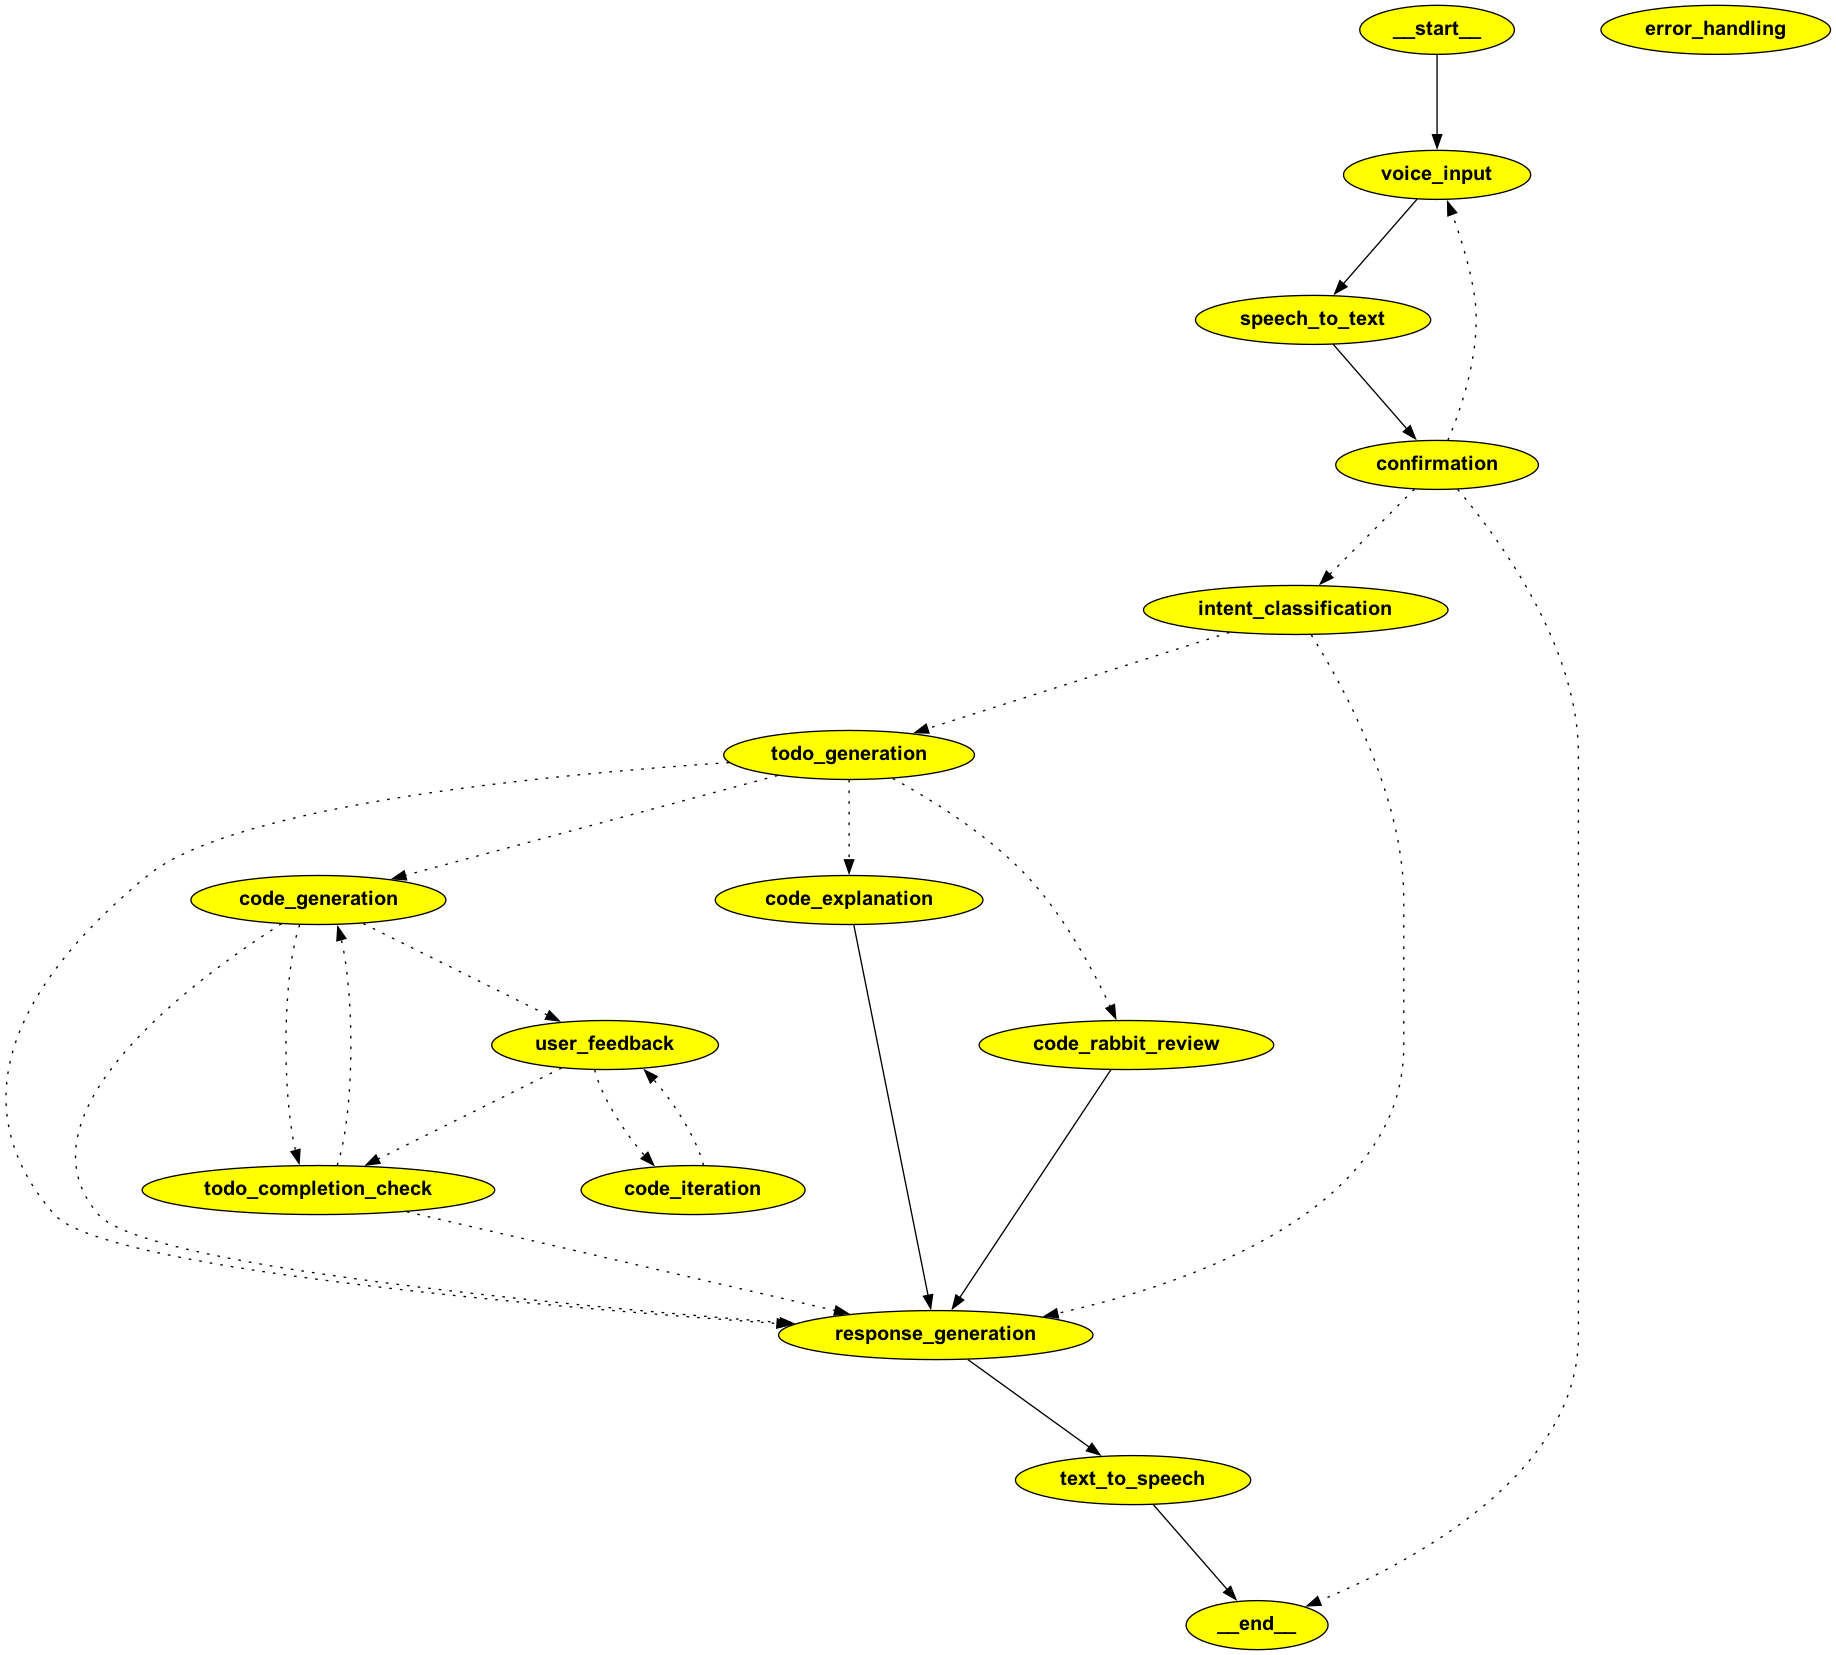

In [10]:
# Then generate the diagram
Image(graph.draw_png())

TASK-1 : SPEECH TO CONFIRMATION:

>> GIVE WAKE UP WORD -- WHISPER-BASED WAKE WORD DETECTION , pvporcupine
>> 


tasks:
1. code gen
2. code review
3. code explanation/debugging

In [11]:
# Interactive Pair Programming Features Demo

def demonstrate_interactive_features():
    """Demonstrate the interactive pair programming features"""
    
    print("🤝 INTERACTIVE PAIR PROGRAMMING FEATURES")
    print("=" * 50)
    
    print("\n1. 🎯 COLLABORATIVE CODE GENERATION")
    print("   - AI generates code with explanations")
    print("   - Asks questions about preferences and edge cases")
    print("   - Suggests alternatives and improvements")
    print("   - Waits for your feedback before proceeding")
    
    print("\n2. 💬 INTERACTIVE FEEDBACK LOOP")
    print("   - You can provide feedback on generated code")
    print("   - AI processes your feedback and explains changes")
    print("   - Multiple iterations until you're satisfied")
    print("   - Code history is maintained for context")
    
    print("\n3. 🔄 ITERATIVE IMPROVEMENT")
    print("   - Each iteration builds on previous feedback")
    print("   - AI explains what changed and why")
    print("   - Collaborative problem-solving approach")
    print("   - Natural conversation flow")
    
    print("\n4. 🧠 CONVERSATIONAL RESPONSES")
    print("   - Questions to understand your needs")
    print("   - Suggestions for best practices")
    print("   - Collaborative decision making")
    print("   - Encouraging and supportive tone")
    
    print("\n5. 📝 TODO-DRIVEN DEVELOPMENT")
    print("   - Breaks down complex tasks into manageable steps")
    print("   - Progress tracking through TODO items")
    print("   - Collaborative planning and execution")
    print("   - Clear milestones and completion status")
    
    print("\n🎉 This creates a true pair programming experience!")
    print("   Like having an AI coding partner sitting next to you!")

# Run the demonstration
demonstrate_interactive_features()


🤝 INTERACTIVE PAIR PROGRAMMING FEATURES

1. 🎯 COLLABORATIVE CODE GENERATION
   - AI generates code with explanations
   - Asks questions about preferences and edge cases
   - Suggests alternatives and improvements
   - Waits for your feedback before proceeding

2. 💬 INTERACTIVE FEEDBACK LOOP
   - You can provide feedback on generated code
   - AI processes your feedback and explains changes
   - Multiple iterations until you're satisfied
   - Code history is maintained for context

3. 🔄 ITERATIVE IMPROVEMENT
   - Each iteration builds on previous feedback
   - AI explains what changed and why
   - Collaborative problem-solving approach
   - Natural conversation flow

4. 🧠 CONVERSATIONAL RESPONSES
   - Questions to understand your needs
   - Suggestions for best practices
   - Collaborative decision making
   - Encouraging and supportive tone

5. 📝 TODO-DRIVEN DEVELOPMENT
   - Breaks down complex tasks into manageable steps
   - Progress tracking through TODO items
   - Collaborative pl